In [152]:
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
plt.rcParams["figure.figsize"] = (20, 9)


### Aggregate all the csv files

##### Read all files from folder and sort them as per the file name
##### Merge all the files

In [157]:
# csvfiles = ['Day1_driver1.csv','Day1_driver2.csv','Day2_driver2_1.csv','Day2_driver1_1.csv','Day2_driver2_2.csv','Day2_driver1_2.csv','Day3_driver2_1.csv','Day3_driver1_1.csv','Day3_driver2_2.csv','Day3_driver1_2.csv','Day3_driver1_3.csv']
# csvfiles = ['Day1_final_data.csv']
path = f"./Data_collection/24_Nov/"
csvfiles = []
for x in os.listdir(path):
    if x.endswith(".csv"):
            csvfiles.append(x)
csvfiles.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
blink_avg_duration_per_minute = []
perclose_per_minute = []
missing_frames_per_minutes = []
number_of_blinks = []
avg_EAR = []
blink_duration = pd.DataFrame(columns=["Start_blink", "End_blink", "Blink_frame", "No_of_frames"])
perclos_value = list()
for x in csvfiles:
    df_alert = pd.read_csv(path+x)
    missing_frames_per_minutes.append(df_alert[df_alert["NewEAR"] == 0].shape[0])
    df_alert = df_alert.loc[(df_alert["EAR"] != 0)]
    df_alert = df_alert.reset_index()  # reindexing to identify the blink duration
    df_alert["NewEMA"] = df_alert["NewEAR"].ewm(4).mean()  # exponetial weighted average moving a
    startframe = list()
    endframe = list()
    frame_no = []
    # print(x)
    if(df_alert.shape[0]>4):
        for i in range(df_alert.shape[0]):
            if df_alert["NewEAR"].iloc[i] < df_alert["NewEAR"].iloc[i-4]*0.75 and i > 4 and (df_alert["FN"].iloc[i] - df_alert["FN"].iloc[i-1]) < 2 and df_alert["NewEAR"].iloc[i]<0.4:
                if len(frame_no) == 0 or (df_alert["FN"].iloc[i] - frame_no[-1] > 8):
                    frame_no.append(df_alert["FN"].iloc[i])
                else:
                    if (df_alert["NewEAR"].iloc[i] < df_alert["NewEAR"].iloc[i-1]):
                        frame_no[-1] = df_alert["FN"].iloc[i]
    number_of_blinks.append(len(frame_no))
    # print(frame_no)
    for i in range(len(frame_no)):
        start_frame, end_frame, blinked_frame = 0, 0, 0
        blinked_frame = frame_no[i]
        earemv = df_alert["NewEAR"].loc[df_alert["FN"]== blinked_frame].iloc[0]
        
        if i == 0:
            sf = 0
        else:
            sf = df_alert.index[df_alert["FN"] == blink_duration["End_blink"].iloc[i-1]][0]
        
        if i == len(frame_no)-1:
            en = df_alert.shape[0]
        else:
            en = df_alert.index[df_alert["FN"] == frame_no[i+1]][0]
        
        for j in range(df_alert.index[df_alert["FN"] == frame_no[i]][0], sf, -1):
            if (df_alert["NewEAR"].iloc[j] > (earemv/0.75)) or df_alert["NewEAR"].iloc[j] > 0.40:
                break
        start_frame = df_alert["FN"].iloc[j]

        for j in range(df_alert.index[df_alert["FN"] == frame_no[i]][0], en):
            if ((df_alert["NewEAR"].iloc[j]) > (earemv/0.75) or (df_alert["NewEAR"].iloc[j] > 0.40)):
                
                break
        if ((df_alert["FN"].iloc[j] - df_alert["FN"].iloc[j-1]) > 2):
            end_frame = df_alert["FN"].iloc[j-1]
        else:
            end_frame = df_alert["FN"].iloc[j]
        
        if end_frame-start_frame > 100:
            duration = 100
        else:
            duration = end_frame-start_frame
        
        blink_duration.loc[blink_duration.shape[0]] = [start_frame, end_frame, blinked_frame, duration]
    
    if len(blink_duration) == 0:
        blink_avg_duration_per_minute.append(0)
    else:
        blink_avg_duration_per_minute.append(sum(blink_duration["No_of_frames"])/blink_duration.shape[0])
    no_of_blinks = blink_duration.shape[0]
    if missing_frames_per_minutes[-1] >1780:
        perclos_value.append(0)
        avg_EAR.append(0) 
    else:
        perclos_value.append(sum(blink_duration["No_of_frames"])/(1800-missing_frames_per_minutes[-1]))
        avg_EAR.append(df_alert["NewEAR"].mean())    
    # file = blink_duration.to_csv(x.split(".")[0]+"_Blink_Duration.csv")
    frame_no.clear()
    blink_duration = blink_duration.drop(blink_duration.index[0:])

Data_day1_analysis = pd.DataFrame(columns=["File_name","MissingFrames_per_min","Blink_per_min", "blink_duration_per_min", "Perclose_per_min", "Avg_EAR"])
Data_day1_analysis["File_name"] = csvfiles
Data_day1_analysis["MissingFrames_per_min"] = missing_frames_per_minutes
Data_day1_analysis["Blink_per_min"] = number_of_blinks
Data_day1_analysis["blink_duration_per_min"] = blink_avg_duration_per_minute
Data_day1_analysis["Perclose_per_min"] = perclos_value
Data_day1_analysis["Avg_EAR"] = avg_EAR
Data_day1_analysis.to_csv("Day_4_data_analsyis_durationfixed.csv")
print(len(number_of_blinks))
print(len(blink_avg_duration_per_minute))
print(len(perclos_value))
print(len(missing_frames_per_minutes))
# file = df_alert.to_csv("Test.csv")


534
534
534
534


#### Based on EMA

In [7]:
# csvfiles = ['Day1_driver1.csv','Day1_driver2.csv','Day2_driver2_1.csv','Day2_driver1_1.csv','Day2_driver2_2.csv','Day2_driver1_2.csv','Day3_driver2_1.csv','Day3_driver1_1.csv','Day3_driver2_2.csv','Day3_driver1_2.csv','Day3_driver1_3.csv']
# csvfiles = ['Day1_final_data.csv']
path = f"./Data_collection/23_Nov/"
csvfiles = []
for x in os.listdir(path):
    if x.endswith(".csv"):
            csvfiles.append(x)
csvfiles.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
blink_avg_duration_per_minute = []
perclose_per_minute = []
missing_frames_per_minutes = []
number_of_blinks = []
blink_duration = pd.DataFrame(columns=["Start_blink", "End_blink", "Blink_frame", "No_of_frames"])
perclos_value = list()
for x in csvfiles:
    df_alert = pd.read_csv(path+x)
    missing_frames_per_minutes.append(df_alert[df_alert["NewEAR"] == 0].shape[0])
    df_alert = df_alert.loc[(df_alert["EAR"] != 0)]
    df_alert = df_alert.reset_index()  # reindexing to identify the blink duration
    df_alert["NewEMA"] = df_alert["NewEAR"].ewm(4).mean()  # exponetial weighted average moving a
    startframe = list()
    endframe = list()
    frame_no = []
    # print(x)
    if(df_alert.shape[0]>4):
        for i in range(df_alert.shape[0]):
            if df_alert["NewEMA"].iloc[i] < df_alert["NewEMA"].iloc[i-4]*0.84 and i > 4 and (df_alert["FN"].iloc[i] - df_alert["FN"].iloc[i-1]) < 2 and df_alert["NewEAR"].iloc[i]<0.4:
                if len(frame_no) == 0 or (df_alert["FN"].iloc[i] - frame_no[-1] > 8):
                    frame_no.append(df_alert["FN"].iloc[i])
                else:
                    if (df_alert["NewEMA"].iloc[i] < df_alert["NewEMA"].iloc[i-1]):
                        frame_no[-1] = df_alert["FN"].iloc[i]
    number_of_blinks.append(len(frame_no))
    # print(frame_no)
    for i in range(len(frame_no)):
        start_frame, end_frame, blinked_frame = 0, 0, 0
        blinked_frame = frame_no[i]
        earemv = df_alert["NewEMA"].loc[df_alert["FN"]== blinked_frame].iloc[0]
        # print(i)
        if i == 0:
            sf = 0
        else:
            # print("end_blink",blink_duration["End_blink"].iloc[i-1])
            sf = df_alert.index[df_alert["FN"] == blink_duration["End_blink"].iloc[i-1]][0]
        # 
        if i == len(frame_no)-1:
            en = df_alert.shape[0]
        else:
            en = df_alert.index[df_alert["FN"] == frame_no[i+1]][0]
        # print(sf)
        # print("start {} and end frame {}".format(sf,en))
        
        for j in range(df_alert.index[df_alert["FN"] == frame_no[i]][0], sf, -1):
        # print(j)
            if (df_alert["NewEMA"].iloc[j] > (earemv/0.92)) or df_alert["NewEAR"].iloc[j] > 0.40:
                start_frame = df_alert["FN"].iloc[j]
                break
            else:
                start_frame = df_alert["FN"].iloc[j]
            # print("start frame",start_frame)
                continue
        # print("threshold",(earemv/0.92))
        # print("------------")
        for j in range(df_alert.index[df_alert["FN"] == frame_no[i]][0], en):
        # print(df_alert["NewEMA"].iloc[j])
            if ((df_alert["NewEMA"].iloc[j]) > (earemv/0.92)) or (df_alert["NewEAR"].iloc[j] > 0.40):
                end_frame = df_alert["FN"].iloc[j]
                break
            else:
                end_frame = df_alert["FN"].iloc[j]
                continue
            
        # print(start_frame)
        if end_frame-start_frame > 100:
            duration = 100
        else:
            duration = end_frame-start_frame
        blink_duration.loc[blink_duration.shape[0]] = [start_frame, end_frame, blinked_frame, duration]
    
    if len(blink_duration) == 0:
        blink_avg_duration_per_minute.append(0)
    else:
        blink_avg_duration_per_minute.append(sum(blink_duration["No_of_frames"])/blink_duration.shape[0])
    no_of_blinks = blink_duration.shape[0]
    perclos_value.append(sum(blink_duration["No_of_frames"])/1800)    
    # file = blink_duration.to_csv(x.split(".")[0]+"_Blink_Duration.csv")
    frame_no.clear()
    blink_duration = blink_duration.drop(blink_duration.index[0:])

Data_day1_analysis = pd.DataFrame(columns=["File_name","MissingFrames_per_min","Blink_per_min", "blink_duration_per_min", "Perclose_per_min"])
Data_day1_analysis["File_name"] = csvfiles
Data_day1_analysis["MissingFrames_per_min"] = missing_frames_per_minutes
Data_day1_analysis["Blink_per_min"] = number_of_blinks
Data_day1_analysis["blink_duration_per_min"] = blink_avg_duration_per_minute
Data_day1_analysis["Perclose_per_min"] = perclos_value
Data_day1_analysis.to_csv("Day3_data_analysis_Enew.csv")
print(len(number_of_blinks))
print(len(blink_avg_duration_per_minute))
print(len(perclos_value))
print(len(missing_frames_per_minutes))
# file = df_alert.to_csv("Test.csv")


14
14
14
14


In [155]:
data = pd.read_csv("Day_1_data_analsyis_durationfixed.csv")
corr = data.iloc[:,3:].corr()

<AxesSubplot:>

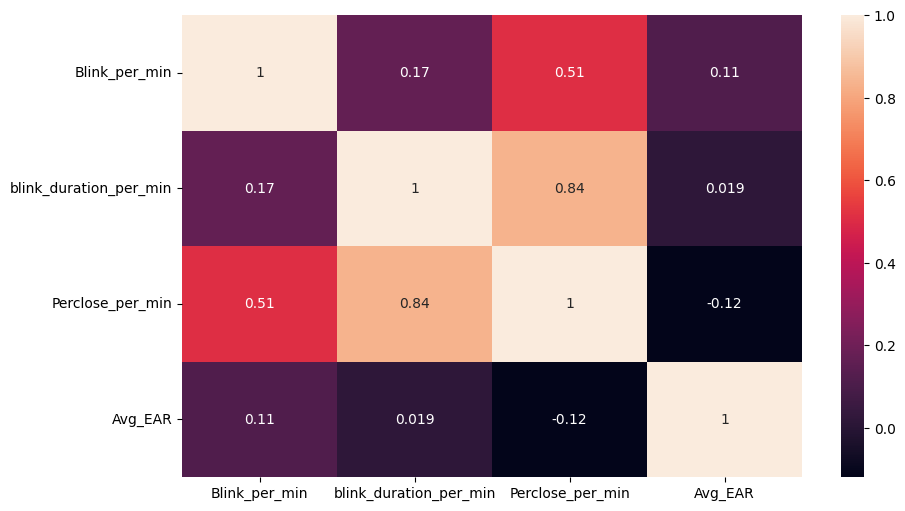

In [156]:
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True)

In [15]:
test_data = pd.read_csv("testdoc.csv")

In [18]:
test_data.drop(test_data.iloc[:,1:5],inplace=True, axis=1)

In [20]:
test_data.drop(test_data.columns[[1,4]],axis=1,inplace=True)

In [21]:
import collections

In [105]:
slindingwindow = []
count_one = 0
count_frame = 0
privous_Fram=float('inf')
globale_counter = 0
for file_name, data in zip(test_data.iloc[:,0],test_data.iloc[:,1]):
    answer=''
    if len(slindingwindow) < 10:
        slindingwindow.append(data)
    else:
        count_one=0
        for i in slindingwindow:
            if i == 1:
                count_one +=1
        slindingwindow.pop(0)
        slindingwindow.append(data)
    if(count_one>=4):
        value = file_name.split("_")[1]
        final_v = list(value)
        # for value_v in final_v[8:]:
        answer = answer.join(final_v[8:])
        # answer.join(final_v[8:])
        if 
        

162742
162841
162940
163138
163237
163336
163435
163633
180009
180108
180207
180306
180405
180504
180603
180702
180801


In [29]:
type(counter)

collections.Counter

In [55]:
test_data.iloc[:,0:2]

,File name,Final
0,VIDEO_18112022132601_1668758161824_EAR.csv,0
1,VIDEO_18112022132700_1668758220821_EAR.csv,1
2,VIDEO_18112022132759_1668758279823_EAR.csv,0
3,VIDEO_18112022132858_1668758338982_EAR.csv,0
4,VIDEO_18112022132957_1668758397827_EAR.csv,0
...,...,...
222,VIDEO_18112022180405_1668774845227_EAR.csv,0
223,VIDEO_18112022180504_1668774904231_EAR.csv,1
224,VIDEO_18112022180603_1668774963224_EAR.csv,0
225,VIDEO_18112022180702_1668775022230_EAR.csv,0
